# Graph-based document classification

* Data preprocessing
* Build Word-word interaction graph
* Calculate basic stats on graph
* Visualization of graph
* Graph representaion learning on word-word graph + visualization
* Build Word-document interaction graph

In [ ]:
import pandas as pd 
import numpy as np
import networkx as nx

from collections import defaultdict
import os
import torch
import torch.nn as nn
import numpy as np
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 8.9 MB/s 
     |████████████████████████████████| 3.5 MB 7.8 MB/s 
     |████████████████████████████████| 2.4 MB 7.9 MB/s 


In [ ]:
! git clone https://github.com/KaiDMML/FakeNewsNet.git

Cloning into 'FakeNewsNet'...
remote: Enumerating objects: 756, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 756 (delta 10), reused 11 (delta 5), pack-reused 735
Receiving objects: 100% (756/756), 43.99 MiB | 25.52 MiB/s, done.
Resolving deltas: 100% (154/154), done.


In [ ]:
fake_news_data = pd.read_csv("./FakeNewsNet/dataset/politifact_fake.csv")
real_news_data = pd.read_csv("./FakeNewsNet/dataset/politifact_real.csv")
news_data = pd.concat([fake_news_data,real_news_data])

In [ ]:
import string
import nltk
import re
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')


def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation+"‘"])
    return punctuationfree

def remove_stopwords(text):
    output= " ".join([i.lower() for i in text.split() if i not in stopwords])
    return output

def clean_text(text):
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
news_data["title"] = news_data["title"].apply(clean_text)
doc_content_list = news_data["title"].values

## Train-test splits

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# document ids
document_ids = np.arange(news_data.shape[0])

# targtes
document_targets = [1] * fake_news_data.shape[0] + [0] * real_news_data.shape[0]
document_targets = np.array(document_targets)

train_ids, test_ids, train_target, test_target = train_test_split(
                                                document_ids,document_targets,
                                                test_size=0.2,random_state=123,stratify=document_targets
)
doc_content_list = doc_content_list[np.append(train_ids,test_ids)]

# sizes
train_size = len(train_ids)
val_size = int(0.1 * train_size)
real_train_size = train_size - val_size
test_size = len(test_ids)

## Build vocabulary

In [ ]:
# build vocabulary set and calculate word frequency
word_freq = {}
for doc_words in doc_content_list:
    words = doc_words.split()
    for word in words:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1
            

sort_orders = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
most_freq = [w[0] for w in sort_orders[:10]]
vocab = [w for w, freq in word_freq.items() if (freq >= 5) and (not w in most_freq)]
vocab_size = len(vocab)
print("Vocaulary size:",vocab_size)

Vocaulary size: 319


In [ ]:
# create document-word dictionary
word_doc_list = defaultdict(set)

for i in range(len(doc_content_list)):
    doc_words = doc_content_list[i]
    words = doc_words.split()
    for word in words:
            word_doc_list[word].add(i)

# calculate term frequency
word_doc_freq = {}
for word, doc_list in word_doc_list.items():
    word_doc_freq[word] = len(doc_list)
    
# word-index mapping
word_id_map = {}
for i in range(vocab_size):
    word_id_map[vocab[i]] = i
    
# inverse mapping
inv_word_mapping = {v+train_size:i for i,v in word_id_map.items()}

## Word-word interaction graph

In [ ]:
# word co-occurence with context windows
# store words in the same window
window_size = 5
windows = []

for doc_words in doc_content_list:
    words = doc_words.split()
    length = len(words)
    if length <= window_size:
        windows.append(words)
    else:
        for j in range(length - window_size + 1):
            window = words[j: j + window_size]
            windows.append(window)

# calculate p(word)
word_window_freq = {}
for window in windows:
    appeared = set()
    for i in range(len(window)):
        word = window[i]
        # continue if the frequency of the word has been calculated
        if word in appeared:
            continue
        if word in word_window_freq:
            word_window_freq[word] += 1
        else:
            word_window_freq[word] = 1
        appeared.add(word)

# calculate co-occurrence frequency (i.e., p(i,j))
word_pair_count = {}
for window in windows:
    for i in range(1, len(window)):
        for j in range(0, i):
            word_i = window[i]
            word_j = window[j]
            if (not word_i in vocab) or (not word_j in vocab):
                continue
            
            word_i_id = word_id_map[word_i]
            word_j_id = word_id_map[word_j]
            if word_i_id == word_j_id:
                continue
            word_pair_str = str(word_i_id) + ',' + str(word_j_id)
            if word_pair_str in word_pair_count:
                word_pair_count[word_pair_str] += 1
            else:
                word_pair_count[word_pair_str] = 1
            # two orders
            word_pair_str = str(word_j_id) + ',' + str(word_i_id)
            if word_pair_str in word_pair_count:
                word_pair_count[word_pair_str] += 1
            else:
                word_pair_count[word_pair_str] = 1

## Creating wor-word edges and calculate edge weights

In [ ]:
row = []
col = []
weight = []

# pmi as weights

num_window = len(windows)

for key in word_pair_count:
    temp = key.split(',')
    i = int(temp[0])
    j = int(temp[1])
    count = word_pair_count[key]
    word_freq_i = word_window_freq[vocab[i]]
    word_freq_j = word_window_freq[vocab[j]]
    # PMI = p(i,j) / (p(i)*p(j))
    pmi = np.log((count / num_window) /
              (word_freq_i * word_freq_j/(num_window * num_window)))
    if pmi <= 0:
        continue
    row.append(train_size + i)
    col.append(train_size + j)
#     row.append(train_size + j)
#     col.append(train_size + i)

    weight.append(pmi)
#     weight.append(pmi)
    
print("Number of edges:",len(row))

Number of edges: 5384


### Word-word graph with networkx

In [ ]:
G = nx.DiGraph()

for source, target, edge_weight in zip(row,col,weight):
    G.add_edge(source, target, weight=edge_weight)

## Problem 1: Statistics of graph
* Please calculate the number of nodes and number of edges
* Please calculate the average degree of the graph (i.e., $|E|/|V|$)
* Use networkx, find out the top-10 words with the highest degree

In [ ]:
print(f"Number of nodes:{G.number_of_nodes()}")
print(f"Number of edges:{G.number_of_edges()}")
print(f"Average degree:{G.number_of_edges() / G.number_of_nodes():.4f}")

Number of nodes:319
Number of edges:5384
Average degree:0.0592


In [ ]:
degree_list = list(tuple(G.degree()))
sorted_degree = sorted(degree_list,key=lambda x:-x[1])

In [ ]:
for k, (node_id, deg) in enumerate(sorted_degree[:10]):
    print(f"Top-{k+1} degree word:\n \t[{inv_word_mapping[node_id]}] with degree {deg}")

Top-1 degree word:
 	[for] with degree 144
Top-2 degree word:
 	[of] with degree 140
Top-3 degree word:
 	[just] with degree 104
Top-4 degree word:
 	[–] with degree 104
Top-5 degree word:
 	[is] with degree 100
Top-6 degree word:
 	[clinton] with degree 98
Top-7 degree word:
 	[after] with degree 96
Top-8 degree word:
 	[says] with degree 94
Top-9 degree word:
 	[and] with degree 94
Top-10 degree word:
 	[with] with degree 92


## Problem 2: Subgraph Visualization 
Visualize a word with degree around 20 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
target_nodeid = sorted_degree[150][0]
subgraph_nodes = [target_nodeid] + list(G.neighbors(target_nodeid))

# assign label dict
labeldict = {index:inv_word_mapping[index] for index in subgraph_nodes}

sub_G = nx.subgraph(G,subgraph_nodes)

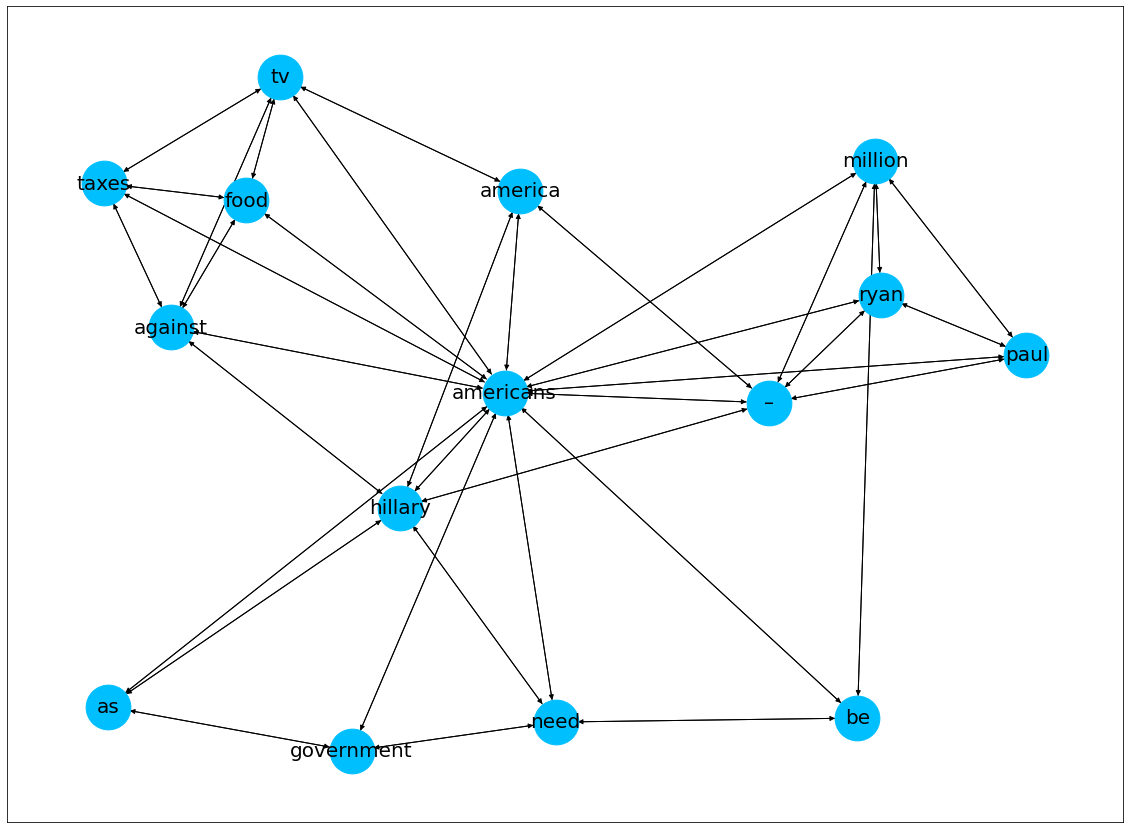

In [ ]:
plt.figure(figsize=(20,15))
configs = dict(
    labels=labeldict,
    node_size=2000,
    node_color="deepskyblue",
    font_size=20,
)
nx.draw_networkx(sub_G,**configs)

## Create Document-word edges

In [ ]:
# doc word frequency
doc_word_freq = defaultdict(lambda:0)

for doc_id in document_ids:
    doc_words = doc_content_list[doc_id]
    words = [w for w in doc_words.split() if w in vocab]
    for word in words:
        word_id = word_id_map[word]
        doc_word_str = str(doc_id) + ',' + str(word_id)
        doc_word_freq[doc_word_str] += 1

for doc_index in document_ids:
    doc_words = doc_content_list[doc_index]
    
    # avoid repeated calculation
    words = set(doc_words.split()) & set(vocab)
    for word in words:
        word_index = word_id_map[word]
        key = str(doc_index) + ',' + str(word_index)
        freq = doc_word_freq[key]
        if doc_index < train_size:
            row.append(doc_index)
        else:
            row.append(doc_index + vocab_size)
        col.append(train_size + word_index)
        
        # TF-IDF as edge weight
        idf = np.log(1.0 * len(document_ids) /
                  word_doc_freq[vocab[word_index]])
        weight.append(freq * idf) # TF*IDF


### Storing all data in `pyg_data`

In [ ]:
from torch_geometric.data import Data
import scipy.sparse as sp
from torch_geometric.utils import from_scipy_sparse_matrix
import torch

In [ ]:
# create a empty Data object
pyg_data = Data()
pyg_data

Data()

In [ ]:
# nodes
node_size = train_size + vocab_size + test_size
pyg_data.num_nodes = node_size
pyg_data.num_classes = 1

# edges
adj = sp.csr_matrix(
    (weight, (row, col)), shape=(node_size, node_size))
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj) # symmetric

edge_index, edge_weight = from_scipy_sparse_matrix(adj)
pyg_data.edge_index = edge_index.long()
pyg_data.edge_weight = edge_weight.float()

In [ ]:
# masks for training, testing
train_masks = torch.zeros(node_size).bool()
train_masks[:train_size] = 1
test_masks = torch.zeros(node_size).bool()
test_masks[-test_size:] = 1 

pyg_data.train_mask = train_masks
pyg_data.test_mask = test_masks

# labels
targets = [torch.FloatTensor(train_target), torch.zeros(vocab_size), torch.FloatTensor(test_target)]
targets = torch.cat(targets,dim=0).long()
pyg_data.target = targets
assert targets.shape[0] == pyg_data.num_nodes

# initial node feature
node_feature = torch.eye(pyg_data.num_nodes)
pyg_data.x = node_feature

In [ ]:
pyg_data

Data(num_nodes=1375, num_classes=1, edge_index=[2, 11790], edge_weight=[11790], train_mask=[1375], test_mask=[1375], target=[1375], x=[1375, 1375])

## Training classification model

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn
import torch

In [ ]:
class TextGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv1(x, edge_index, edge_weight).relu()
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x#.flatten()

In [ ]:
# model configurations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dim = 16
model = TextGCN(pyg_data.num_nodes, dim, pyg_data.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss(reduction="none")
print(model)

TextGCN(
  (conv1): GCNConv(1375, 16)
  (conv2): GCNConv(16, 1)
)


In [ ]:
# map data to GPU device
pyg_data.x = pyg_data.x.to(device)
pyg_data.edge_index = pyg_data.edge_index.to(device)
pyg_data.edge_weight = pyg_data.edge_weight.to(device)
pyg_data.target = pyg_data.target.to(device).float()

In [ ]:
for epoch in range(400):
    logits = model(pyg_data.x, pyg_data.edge_index, pyg_data.edge_weight).flatten()
    loss = criterion(logits, pyg_data.target)[pyg_data.train_mask]
    loss = loss.mean()    
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # evaluation
    # calculate the train/test accuracy
    probs = torch.sigmoid(logits)
    accurate_prediction = ((probs>0.5)*1 == pyg_data.target)
    train_accuracy = accurate_prediction[pyg_data.train_mask].float().mean().item()
    test_accuracy = accurate_prediction[pyg_data.test_mask].float().mean().item()
    print(f"Train Accuracy:{train_accuracy:.4f} | Test Accuracy:{test_accuracy:.4f}")

Train Accuracy:0.5012 | Test Accuracy:0.5472
Train Accuracy:0.5723 | Test Accuracy:0.5896
Train Accuracy:0.5912 | Test Accuracy:0.5991
Train Accuracy:0.5912 | Test Accuracy:0.5991
Train Accuracy:0.5912 | Test Accuracy:0.5991
Train Accuracy:0.5972 | Test Accuracy:0.6132
Train Accuracy:0.5948 | Test Accuracy:0.6038
Train Accuracy:0.5948 | Test Accuracy:0.5991
Train Accuracy:0.5912 | Test Accuracy:0.5991
Train Accuracy:0.6007 | Test Accuracy:0.5991
Train Accuracy:0.5983 | Test Accuracy:0.5896
Train Accuracy:0.5995 | Test Accuracy:0.5943
Train Accuracy:0.6055 | Test Accuracy:0.5943
Train Accuracy:0.6019 | Test Accuracy:0.5943
Train Accuracy:0.6043 | Test Accuracy:0.5896
Train Accuracy:0.6078 | Test Accuracy:0.5943
Train Accuracy:0.6019 | Test Accuracy:0.5943
Train Accuracy:0.6043 | Test Accuracy:0.5943
Train Accuracy:0.6019 | Test Accuracy:0.5943
Train Accuracy:0.6055 | Test Accuracy:0.5943
Train Accuracy:0.6078 | Test Accuracy:0.5896
Train Accuracy:0.6256 | Test Accuracy:0.6038
Train Accu

## Explain your prediction via data visualization with GNNExplainer

In [ ]:
from torch_geometric.nn import GNNExplainer
import matplotlib.pyplot as plt

In [ ]:
# use target as node color
colors = pyg_data.target
overall_labels = {i:f"Doc_{i}" for i in range(node_size)}
overall_labels.update(inv_word_mapping)

In [ ]:
vocab_nodes = list(range(train_size+vocab_size))
logits = model(pyg_data.x, pyg_data.edge_index, pyg_data.edge_weight).flatten()
probs = torch.sigmoid(logits)
probs[vocab_nodes] = 0.5
values,indices = torch.topk(probs,20,largest=True)

### Find document index with top-20 highest probability of being fake news

In [ ]:
print("-------------Document index with highest predicted probability in testing set.")
for node_idx in indices.cpu().numpy():
    explainer = GNNExplainer(model, epochs=20, return_type='raw',lr=1e-3,log=False)
    node_feat_mask, edge_mask = explainer.explain_node(int(node_idx), pyg_data.x, pyg_data.edge_index,
                                                   edge_weight=pyg_data.edge_weight)
    print(f"Document index:{node_idx} | Predicted prob: {probs[node_idx].item():.4f} | Number of nodes:",edge_mask.bool().sum().item())

-------------Document index with highest predicted probability in testing set.
Document index:1310 | Predicted prob: 0.9166 | Number of nodes: 1534
Document index:1228 | Predicted prob: 0.9103 | Number of nodes: 4592
Document index:1198 | Predicted prob: 0.9098 | Number of nodes: 342
Document index:1175 | Predicted prob: 0.9036 | Number of nodes: 3020
Document index:1203 | Predicted prob: 0.9004 | Number of nodes: 3698
Document index:1171 | Predicted prob: 0.8923 | Number of nodes: 2048
Document index:1316 | Predicted prob: 0.8885 | Number of nodes: 2282
Document index:1358 | Predicted prob: 0.8767 | Number of nodes: 1936
Document index:1281 | Predicted prob: 0.8691 | Number of nodes: 1512
Document index:1324 | Predicted prob: 0.8364 | Number of nodes: 3300
Document index:1269 | Predicted prob: 0.8333 | Number of nodes: 240
Document index:1248 | Predicted prob: 0.8274 | Number of nodes: 3024
Document index:1335 | Predicted prob: 0.8199 | Number of nodes: 188
Document index:1288 | Predi

### Subgraph visualization of fake news

Explain node 1198: 100%|██████████| 20/20 [00:00<00:00, 251.41it/s]


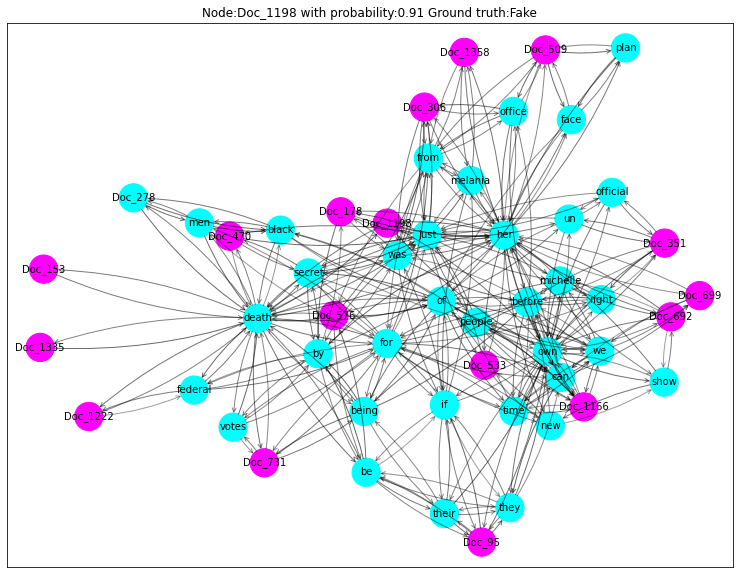

In [ ]:
# train explainer
explainer = GNNExplainer(model, epochs=20, return_type='raw',lr=1e-3)
node_idx = 1198 # you can change the index according to the index above
node_feat_mask, edge_mask = explainer.explain_node(node_idx, pyg_data.x, pyg_data.edge_index,
                                                   edge_weight=pyg_data.edge_weight)

# convert index to label
subgraph_nodes = pyg_data.edge_index[:,edge_mask.bool()].detach().cpu().numpy().flatten()
subgraph_labels = {i:overall_labels[i] for i in subgraph_nodes}


# draw plots
plt.figure(figsize=(13,10))
probs = torch.sigmoid(logits)[node_idx].item()
answer = "Real" if pyg_data.target[node_idx].item() == 0 else "Fake"
ax, G = explainer.visualize_subgraph(node_idx, pyg_data.edge_index, edge_mask, y=pyg_data.target,labels=subgraph_labels)
plt.title(f"Node:{subgraph_labels[node_idx]} with probability:{probs:.2f} Ground truth:{answer}")
plt.show()

### Find document index with top-20 lowest probability of being fake news

In [ ]:
vocab_nodes = list(range(train_size+vocab_size))
logits = model(pyg_data.x, pyg_data.edge_index, pyg_data.edge_weight).flatten()
probs = torch.sigmoid(logits)
probs[vocab_nodes] = 0.5
values,indices = torch.topk(probs,20,largest=False)

In [ ]:
print("-------------Document index with lowest predicted probability in testing set.")
for node_idx in indices.cpu().numpy():
    explainer = GNNExplainer(model, epochs=20, return_type='raw',lr=1e-3,log=False)
    node_feat_mask, edge_mask = explainer.explain_node(int(node_idx), pyg_data.x, pyg_data.edge_index,
                                                   edge_weight=pyg_data.edge_weight)
    print(f"Document index:{node_idx} | Predicted prob: {probs[node_idx].item():.4f} | Number of nodes:",edge_mask.bool().sum().item())

-------------Document index with lowest predicted probability in testing set.
Document index:1367 | Predicted prob: 0.0382 | Number of nodes: 720
Document index:1374 | Predicted prob: 0.0403 | Number of nodes: 766
Document index:1178 | Predicted prob: 0.0468 | Number of nodes: 438
Document index:1302 | Predicted prob: 0.0468 | Number of nodes: 438
Document index:1190 | Predicted prob: 0.0468 | Number of nodes: 438
Document index:1333 | Predicted prob: 0.0468 | Number of nodes: 438
Document index:1303 | Predicted prob: 0.0539 | Number of nodes: 610
Document index:1176 | Predicted prob: 0.0589 | Number of nodes: 784
Document index:1183 | Predicted prob: 0.0603 | Number of nodes: 430
Document index:1181 | Predicted prob: 0.0619 | Number of nodes: 646
Document index:1369 | Predicted prob: 0.0645 | Number of nodes: 32
Document index:1242 | Predicted prob: 0.0646 | Number of nodes: 32
Document index:1282 | Predicted prob: 0.0647 | Number of nodes: 32
Document index:1289 | Predicted prob: 0.0

### Subgraph visualization of real news

Explain node 1183: 100%|██████████| 20/20 [00:00<00:00, 229.19it/s]


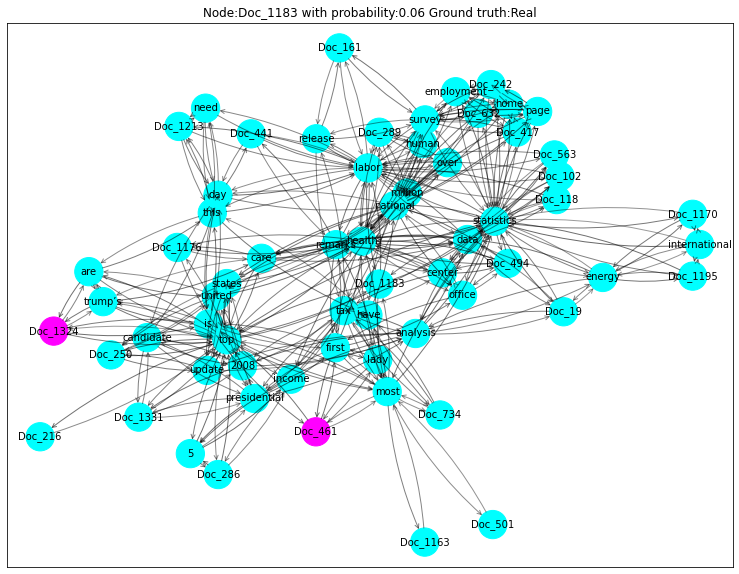

In [ ]:
# train explainer
explainer = GNNExplainer(model, epochs=20, return_type='raw',lr=1e-3)
node_idx = 1183
node_feat_mask, edge_mask = explainer.explain_node(node_idx, pyg_data.x, pyg_data.edge_index,
                                                   edge_weight=pyg_data.edge_weight)

# convert index to label
subgraph_nodes = pyg_data.edge_index[:,edge_mask.bool()].detach().cpu().numpy().flatten()
subgraph_labels = {i:overall_labels[i] for i in subgraph_nodes}


# draw plots
plt.figure(figsize=(13,10))
probs = torch.sigmoid(logits)[node_idx].item()
answer = "Real" if pyg_data.target[node_idx].item() == 0 else "Fake"
ax, G = explainer.visualize_subgraph(node_idx, pyg_data.edge_index, edge_mask, y=pyg_data.target,labels=subgraph_labels)
plt.title(f"Node:{subgraph_labels[node_idx]} with probability:{probs:.2f} Ground truth:{answer}")
plt.show()